In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

class GrayScott:
    def __init__(self, n, Du, Dv, F, k):
        self.n = n
        self.Du = Du
        self.Dv = Dv
        self.F = F
        self.k = k
        self.u, self.v = self.init(n)
        self.utot,self.vtot = [],[]

    def init(self, n):
        u = np.ones((n + 2, n + 2)) * 0.5
        v = np.zeros((n + 2, n + 2)) #*0.5
        x, y = np.meshgrid(np.linspace(0, 1, n + 2), np.linspace(0, 1, n + 2))
        mask = (0.45 < x) & (x < 0.55) & (0.45 < y) & (y < 0.55)
        u[mask] = 0.5
        v[mask] = 0.25
        return u, v

    def periodic_bc(self, u):
        u[0, :] = u[-2, :]
        u[-1, :] = u[1, :]
        u[:, 0] = u[:, -2]
        u[:, -1] = u[:, 1]

    def laplacian(self, u):
        return (u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - 4*u[1:-1, 1:-1])

    def numpy_grayscott(self, U, V, Du, Dv, F, k, dt):
        Lu = self.laplacian(U)
        Lv = self.laplacian(V)
        uvv = U[1:-1, 1:-1]*V[1:-1, 1:-1]*V[1:-1, 1:-1]
        U[1:-1, 1:-1] += dt*(Du*Lu - uvv + F*(1 - U[1:-1, 1:-1]))
        V[1:-1, 1:-1] += dt*(Dv*Lv + uvv - (F + k)*V[1:-1, 1:-1])
        self.periodic_bc(U)
        self.periodic_bc(V)
        return U, V
    
    def run(self, max_time, dt):
        self.u, self.v = self.init(self.n)

        for _ in np.arange(0, max_time, dt):
            self.u, self.v = self.numpy_grayscott(self.u, self.v, self.Du, self.Dv, self.F, self.k, dt)
            self.utot.append(np.sum(self.u))
            self.vtot.append(np.sum(self.v))

    def plot(self, max_time: float, dt: float, tickstep: float, savefig: bool):
    
        self.run(max_time, dt)

        plt.figure(figsize=(8.5, 7))
        ax = sns.heatmap(self.u, cmap='jet', vmin=0, vmax=1)
        ax.set_xlabel('x', fontsize=30)
        ax.set_ylabel('y', fontsize=30)
        ax.invert_yaxis()
        ax.tick_params(left=True, bottom=True)
        ax.set_xticks(range(0, self.n + tickstep, tickstep))
        ax.set_yticks(range(0, self.n + tickstep, tickstep))
        ax.set_xticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=30)
        ax.set_yticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=30)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=30)
        cbar.set_label("concentration u", fontsize=30)

        plt.tight_layout()

        if savefig:
            plt.savefig(f"/GS_end.png", dpi=300, bbox_inches='tight')
    
    def gif(self, max_time: float, dt: float, tickstep: float):
        self.u, self.v = self.init(self.n)

        for _ in np.arange(0, max_time, dt):
            self.u, self.v = self.numpy_grayscott(self.u, self.v, self.Du, self.Dv, self.F, self.k, dt)
            self.utot.append(np.sum(self.u))
            self.vtot.append(np.sum(self.v))
            plt.figure(figsize=(8.5, 7))
            ax = sns.heatmap(self.u, cmap='jet', vmin=0, vmax=1)
            ax.set_xlabel('x', fontsize=30)
            ax.set_ylabel('y', fontsize=30)
            ax.invert_yaxis()
            ax.tick_params(left=True, bottom=True)
            ax.set_xticks(range(0, self.n + tickstep, tickstep))
            ax.set_yticks(range(0, self.n + tickstep, tickstep))
            ax.set_xticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=30)
            ax.set_yticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=30)
            cbar = ax.collections[0].colorbar
            cbar.ax.tick_params(labelsize=30)
            cbar.set_label("concentration u", fontsize=30)

            plt.tight_layout()
            plt.savefig(f"gif/GSF{_}.png", dpi=300, bbox_inches='tight')
            plt.close()

    def concentration(self,t):
        plt.plot(np.arange(0,t,1),self.utot,label='Concentration u')
        plt.plot(np.arange(0,t,1),self.vtot,label= 'Concentration v')
        plt.legend()
        plt.show()
        plt.close()

        plt.plot(self.utot,self.vtot,label='Phase Space')
        plt.xlabel('concentration u')
        plt.ylabel('concentration v')
        plt.legend()
        plt.show()

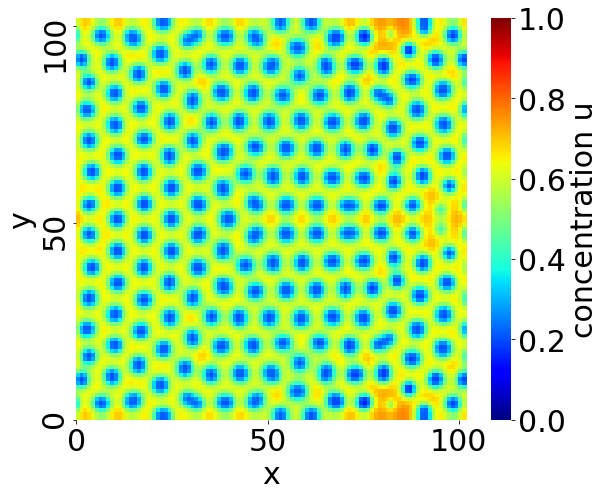

In [5]:
t=30000     
gs = GrayScott(n=100, Du=0.090, Dv=0.03, F=0.018, k=0.055)                                                                                   
gs.plot(max_time =t, dt=1, tickstep=50, savefig=False)  

KeyboardInterrupt: 

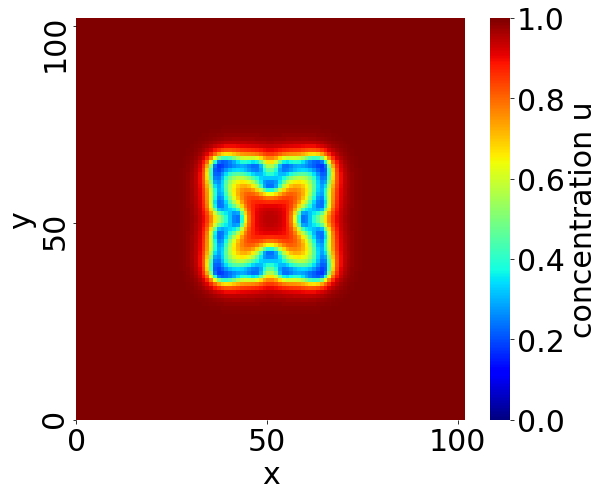

In [6]:
gs.gif(max_time=t,dt=1,tickstep=50)

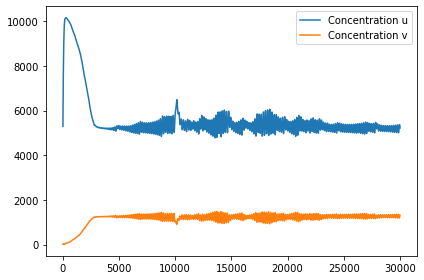

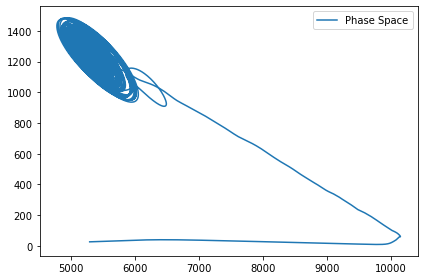

In [206]:
gs.concentration(t)